# Random Forest for VM Criticality

Minimal, commented walkthrough to train and evaluate a Random Forest classifier on the VM request table. Assumes the final dataset lives at `data_final/vm_request_table_with_split.parquet` (placed at repo root).

What this notebook covers:
- load data and respect the time-based train/val/test split
- keep only arrival-time + tenant-history features (avoid label leakage)
- simple preprocessing (one-hot for the lone categorical column)
- train a baseline RandomForest with class weighting
- evaluate on val/test (AUC-PR, ROC-AUC, PR/ROC curves, confusion matrix)
- inspect feature importances
- save the fitted pipeline and metrics

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

pd.set_option("display.max_columns", 120)

DATA_PATH = Path("../data_final/vm_request_table_with_split.parquet")
ARTIFACT_DIR = Path("../models/artifacts")
RANDOM_SEED = 42

assert DATA_PATH.exists(), f"Missing dataset at {DATA_PATH}"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# Load the full table once; we'll slice by the time-based split column.
df = pd.read_parquet(DATA_PATH)
print("Data shape:", df.shape)
print("Split counts:\n", df["split"].value_counts())
print("Positive rate (critical=1):", df["critical"].mean().round(4))

Data shape: (894280, 70)
Split counts:
 split
train    632426
test     131849
val      130005
Name: count, dtype: int64
Positive rate (critical=1): 0.0261


In [3]:
# Define which columns are safe to use at VM arrival time (no label leakage).
# These come from README; adjust if preprocessing changes.
TARGET_COL = "critical"
SPLIT_COL = "split"
ID_COLS = ["vm_id", "subscription_id", "deployment_id"]

ARRIVAL_FEATURES = [
    # Identifiers/time (exclude vm_id as a feature)
    "subscription_id",  # can be used for history joins, but we will drop it below to avoid ID leakage
    "deployment_id",    # same note as subscription_id
    "ts_vm_created",
    "day_idx",
    "hour_of_day",
    # Static VM config & deployment metadata
    "vm_category",
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    # Tenant static info
    "ts_first_vm_created",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour",
    # Tenant history features (based only on past VMs)
    "hist_n_vms",
    "hist_n_critical",
    "hist_has_past",
    "hist_critical_frac",
    "hist_lifetime_mean",
    "hist_lifetime_std",
    "hist_cpu_mean_mean",
    "hist_p95_mean",
    "hist_frac_gt60_mean",
    "hist_day_night_ratio_mean",
]

# Columns that must NOT be used for prediction (future behavior / label components / split markers).
POSTHOC_COLS = [
    "ts_vm_deleted",
    "lifetime_sec",
    "lifetime_hours",
    "max_cpu",
    "avg_cpu",
    "p95_max_cpu",
    "n_readings",
    "max_cpu_right",
    "cpu_mean",
    "cpu_std",
    "cpu_frac_gt_60",
    "cpu_frac_gt_80",
    "day_cpu_mean",
    "night_cpu_mean",
    "day_night_ratio",
    # Hourly CPU columns
    *[f"cpu_hour_{h}_mean" for h in range(24)],
    # Label components and split metadata
    "long_lived",
    "sustained_high",
    "strong_diurnal",
    TARGET_COL,
    SPLIT_COL,
]

# Build the final feature list: use arrival features that actually exist, drop raw IDs to avoid leakage.
feature_cols = [c for c in ARRIVAL_FEATURES if c in df.columns and c not in ID_COLS]
missing = sorted(set(ARRIVAL_FEATURES) - set(df.columns))
if missing:
    print("Warning: missing arrival features in dataset:", missing)

print(f"Using {len(feature_cols)} features:")
print(feature_cols)

Using 23 features:
['ts_vm_created', 'day_idx', 'hour_of_day', 'vm_category', 'vm_virtual_core_count', 'vm_memory_gb', 'vm_mem_per_core', 'deployment_size', 'log_deployment_size', 'ts_first_vm_created', 'count_vms_created', 'sub_first_day', 'sub_first_hour', 'hist_n_vms', 'hist_n_critical', 'hist_has_past', 'hist_critical_frac', 'hist_lifetime_mean', 'hist_lifetime_std', 'hist_cpu_mean_mean', 'hist_p95_mean', 'hist_frac_gt60_mean', 'hist_day_night_ratio_mean']


In [4]:
# Split the data.
train_df = df[df[SPLIT_COL] == "train"].copy()
val_df = df[df[SPLIT_COL] == "val"].copy()
test_df = df[df[SPLIT_COL] == "test"].copy()

X_train, y_train = train_df[feature_cols], train_df[TARGET_COL]
X_val, y_val = val_df[feature_cols], val_df[TARGET_COL]
X_test, y_test = test_df[feature_cols], test_df[TARGET_COL]

categorical_cols = [c for c in feature_cols if c == "vm_category"]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

print("Train/val/test sizes:", len(X_train), len(X_val), len(X_test))

Train/val/test sizes: 632426 130005 131849


In [5]:
# Preprocessing: one-hot encode vm_category, pass-through numerics.
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_cols),
        ("num", "passthrough", numeric_cols),
    ],
    remainder="drop",
)

# Baseline Random Forest; class_weight balances the skewed critical label.
# rf_clf = RandomForestClassifier(
#     n_estimators=300,
#     max_depth=None,
#     min_samples_leaf=2,
#     n_jobs=-1,
#     class_weight="balanced",
#     random_state=RANDOM_SEED,
#     verbose=1,  # print tree-building progress so training isn't silent
# )
rf_clf = RandomForestClassifier(
    n_estimators=600,
    max_depth=16,
    min_samples_leaf=2,
    max_features=0.4,
    n_jobs=-1,
    class_weight="balanced",
    random_state=RANDOM_SEED,
    verbose=1,
)

model = Pipeline([
    ("preprocess", preprocess),
    ("rf", rf_clf),
])

model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['vm_category']),
                                                 ('num', 'passthrough',
                                                  ['ts_vm_created', 'day_idx',
                                                   'hour_of_day',
                                                   'vm_virtual_core_count',
                                                   'vm_memory_gb',
                                                   'vm_mem_per_core',
                                                   'deployment_size',
                                                   'log_deployment_size',
                                                   'ts_first_vm_created',
                                                   'count_vms_created',
                                                   'sub_first_day',
                                                   'sub_fir...
                                                   'hist_n_vms',
                                                   'hist_n_critical',
                                                   'hist_has_past',
                                                   'hist_critical_frac',
                                                   'hist_lifetime_mean',
                                                   'hist_lifetime_std',
                                                   'hist_cpu_mean_mean',
                                                   'hist_p95_mean',
                                                   'hist_frac_gt60_mean',
                                                   'hist_day_night_ratio_mean'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=16,
                                        max_features=0.4, min_samples_leaf=2,
                                        n_estimators=600, n_jobs=-1,
                                        random_state=42, verbose=1))])

In [6]:
# Train the model.
model.fit(X_train, y_train)
print("Model trained.")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed:  2.5min


Model trained.


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.5min finished


In [7]:
def evaluate_split(model, X, y, split_name: str, threshold: float = 0.5) -> dict:
    """Compute key metrics and plot PR/ROC for a split."""
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)

    auc_pr = average_precision_score(y, proba)
    auc_roc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, preds)

    cm_df = pd.DataFrame(
        cm,
        index=["Actual: not critical", "Actual: critical"],
        columns=["Pred: not critical", "Pred: critical"],
    )

    print(f"\n[{split_name}] AUC-PR={auc_pr:.4f}, AUC-ROC={auc_roc:.4f}, threshold={threshold}")
    print("Confusion matrix (counts):\n", cm_df)
    print("Classification report:\n", classification_report(y, preds, digits=3, zero_division=0))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[0])
    axes[0].set_title(f"PR curve – {split_name}")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"ROC curve – {split_name}")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": auc_pr, "auc_roc": auc_roc, "confusion": cm.tolist()}


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.2s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.3s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.3s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.5s finished



[val] AUC-PR=0.1467, AUC-ROC=0.8882, threshold=0.23160804020100503
Confusion matrix (counts):
                       Pred: not critical  Pred: critical
Actual: not critical              105355           20701
Actual: critical                     662            3287
Classification report:
               precision    recall  f1-score   support

           0      0.994     0.836     0.908    126056
           1      0.137     0.832     0.235      3949

    accuracy                          0.836    130005
   macro avg      0.565     0.834     0.572    130005
weighted avg      0.968     0.836     0.888    130005



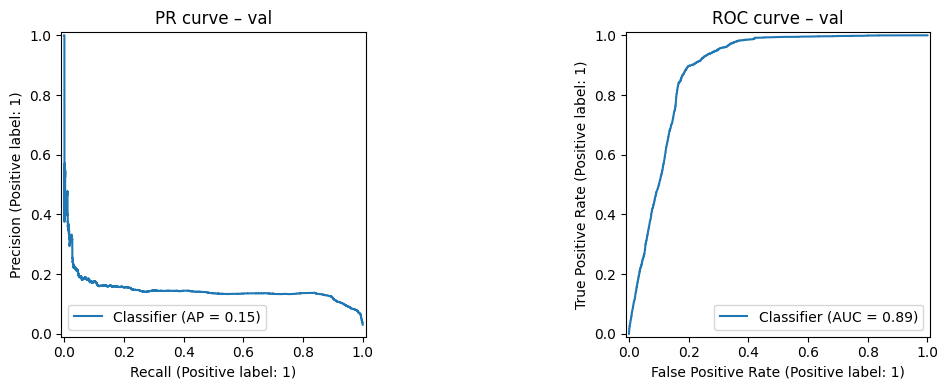

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=22)]: Done 156 tasks      | elapsed:    0.1s
[Parallel(n_jobs=22)]: Done 406 tasks      | elapsed:    0.4s
[Parallel(n_jobs=22)]: Done 600 out of 600 | elapsed:    0.5s finished



[test] AUC-PR=0.1111, AUC-ROC=0.8865, threshold=0.23160804020100503
Confusion matrix (counts):
                       Pred: not critical  Pred: critical
Actual: not critical              109017           19960
Actual: critical                     639            2233
Classification report:
               precision    recall  f1-score   support

           0      0.994     0.845     0.914    128977
           1      0.101     0.778     0.178      2872

    accuracy                          0.844    131849
   macro avg      0.547     0.811     0.546    131849
weighted avg      0.975     0.844     0.898    131849



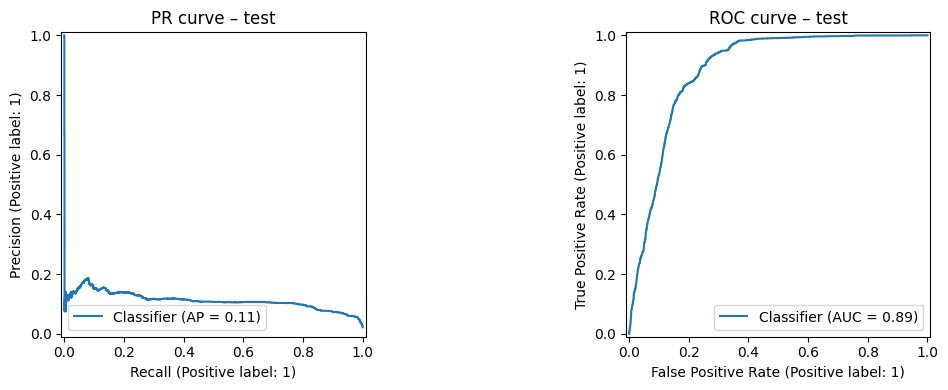

In [9]:
# proba_val = model.predict_proba(X_val)[:,1]
# thresholds = np.linspace(0.01, 0.5, 200)
# best = max(((t, average_precision_score(y_val, (proba_val>=t).astype(int)))
#             for t in thresholds),
#            key=lambda x: x[1])
# best_threshold = best[0]
# metrics_val = evaluate_split(model, X_val, y_val, "val", threshold=best_threshold)
# metrics_test = evaluate_split(model, X_test, y_test, "test", threshold=best_threshold)

from sklearn.metrics import f1_score, precision_recall_curve

proba_val = model.predict_proba(X_val)[:, 1]

candidates = np.linspace(0.01, 0.5, 200)
best_threshold = max(candidates, key=lambda t: f1_score(y_val, (proba_val >= t).astype(int)))

# Optional: get the PR curve arrays too
prec, rec, pr_thresholds = precision_recall_curve(y_val, proba_val)

metrics_val = evaluate_split(model, X_val, y_val, "val", threshold=best_threshold)
metrics_test = evaluate_split(model, X_test, y_test, "test", threshold=best_threshold)


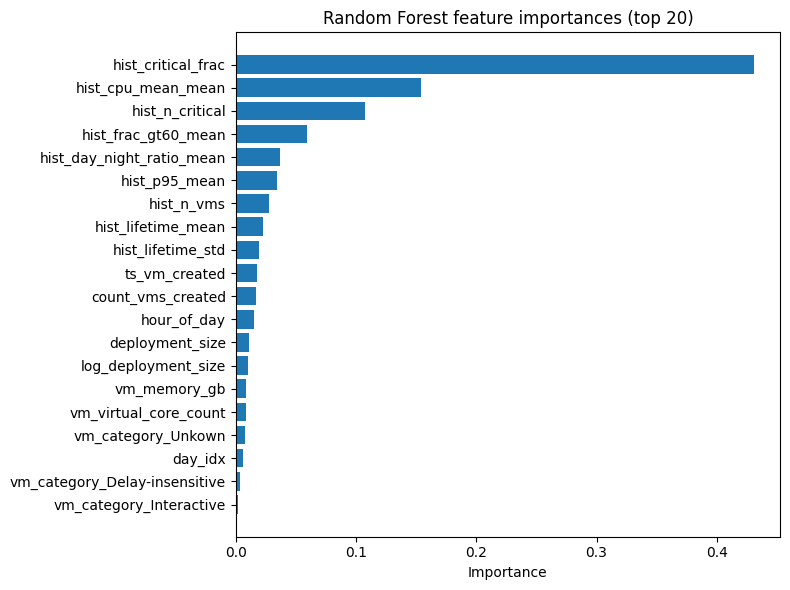

[{'feature': 'hist_critical_frac', 'importance': 0.4310471900283157},
 {'feature': 'hist_cpu_mean_mean', 'importance': 0.1541419139957933},
 {'feature': 'hist_n_critical', 'importance': 0.10718136308784429},
 {'feature': 'hist_frac_gt60_mean', 'importance': 0.059331027273886165},
 {'feature': 'hist_day_night_ratio_mean', 'importance': 0.03670914908002528},
 {'feature': 'hist_p95_mean', 'importance': 0.034557522112166686},
 {'feature': 'hist_n_vms', 'importance': 0.027724836019471132},
 {'feature': 'hist_lifetime_mean', 'importance': 0.02288480222784727},
 {'feature': 'hist_lifetime_std', 'importance': 0.019507491820325667},
 {'feature': 'ts_vm_created', 'importance': 0.017898135417121448},
 {'feature': 'count_vms_created', 'importance': 0.01704726010163553},
 {'feature': 'hour_of_day', 'importance': 0.014931399137735226},
 {'feature': 'deployment_size', 'importance': 0.010647499538690196},
 {'feature': 'log_deployment_size', 'importance': 0.010386786825707418},
 {'feature': 'vm_memory_

In [10]:
# Feature importances: map back to readable feature names (including one-hot columns).
rf = model.named_steps["rf"]
ohe = model.named_steps["preprocess"].named_transformers_["cat"]

cat_features = list(ohe.get_feature_names_out(categorical_cols)) if categorical_cols else []
all_features = cat_features + numeric_cols

importances = rf.feature_importances_
top_k = 20
idx = np.argsort(importances)[::-1][:top_k]

plt.figure(figsize=(8, 6))
plt.barh(np.array(all_features)[idx][::-1], importances[idx][::-1])
plt.xlabel("Importance")
plt.title("Random Forest feature importances (top 20)")
plt.tight_layout()
plt.show()

feature_ranking = [
    {"feature": all_features[i], "importance": float(importances[i])}
    for i in idx
]
feature_ranking

In [11]:
# Save the trained pipeline and simple metrics for reuse.
import joblib

model_path = ARTIFACT_DIR / "random_forest_pipeline.joblib"
metrics_path = ARTIFACT_DIR / "random_forest_metrics.json"

joblib.dump(model, model_path)

with metrics_path.open("w") as f:
    json.dump(
        {
            "val": metrics_val,
            "test": metrics_test,
            "params": model.named_steps["rf"].get_params(),
            "features": feature_cols,
            "categorical": categorical_cols,
            "numeric": numeric_cols,
            "random_seed": RANDOM_SEED,
        },
        f,
        indent=2,
    )

print(f"Saved model to {model_path}")
print(f"Saved metrics to {metrics_path}")

Saved model to ../models/artifacts/random_forest_pipeline.joblib
Saved metrics to ../models/artifacts/random_forest_metrics.json
